# Problem Statement:

We intend to explore the Iowa State liquor sales dataset to identify the features most correlated with sales and make recommendations -- at the county level -- on the counties we feel will generate the highest sales.

## Goals and Criteria for success

Our goal is to identify the features most correlated with sales and build a model that best explains the factors that drive sales. To do this, we've used the provided data and added additional demographic data that the liquor sales literature suggest may lead to increased liquor sales, including: proportion of the population that's male vs. female, employment data and the proportion of the population 21 years or older. 

Our criteria for success would be a model with a high r^2 that remains high after cross validation and a low MSE.

# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [134]:
## LIBRARY AND DATA LOADING
# Numeric and statistics packages:
import numpy as np
import scipy.stats as stats

# Pandas handles dataset loading and manipulation:
import pandas as pd

# import the plotting functions:
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly
# import plotly.plotly as py
# import plotly.graph_objs as go
import math
import csv
from datetime import datetime

#Model Building Libraries
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_predict, cross_val_score

# Initialize plotly notebook mode:
# plotly.offline.init_notebook_mode()

# Setup matplotlib to display in notebook:
%matplotlib inline

In [4]:
## Load the data into a DataFrame
df = pd.read_csv('../assets/Iowa_Liquor_sales_sample_10pct.csv', encoding='latin1')
df.head(3)


,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,03/02/2016,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,02/11/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34


In [5]:
## Load Demographic per County data into a DataFrame
demo_df = pd.read_csv('/Users/mikeroman/Downloads/Total_County_Population_by_Year.csv')
demo_df.head(3)

,FIPS,County,Year,Population,Primary County Coordinates
0,19001,Adair County,July 01 2015,7228,"(41.3307464, -94.4709413)"
1,19003,Adams County,July 01 2015,3796,"(41.0289839, -94.6991849)"
2,19005,Allamakee County,July 01 2015,13886,"(43.2842838, -91.3780923)"


In [6]:
#Remove the word "County" from each element, leaving us with just the county name. 
demo_df['County'] = [x.replace(" County", "") if " County" in x else x for x in demo_df['County']]
demo_df.head(3)

,FIPS,County,Year,Population,Primary County Coordinates
0,19001,Adair,July 01 2015,7228,"(41.3307464, -94.4709413)"
1,19003,Adams,July 01 2015,3796,"(41.0289839, -94.6991849)"
2,19005,Allamakee,July 01 2015,13886,"(43.2842838, -91.3780923)"


In [7]:
#Just taking the population column from our dataset. 
demo_df = demo_df.drop(demo_df.columns[[0, 2, 4]], axis=1) 
demo_df.head(3)

,County,Population
0,Adair,7228
1,Adams,3796
2,Allamakee,13886


In [10]:
## Load Employment data per County data into a DataFrame
empl_df = pd.read_csv('/Users/mikeroman/Documents/Employment_Data_Iowa_2015.csv')
empl_df.columns = ['County', 'Average of LABORFORCE', 'Average of EMPLAB','Average of UNEMP', 'Average of UNEMPRATE']
empl_df.head(3)

,County,Average of LABORFORCE,Average of EMPLAB,Average of UNEMP,Average of UNEMPRATE
0,Adair County,4268.33,4131.67,135.83,3.17
1,Adams County,2300.83,2235.83,63.33,2.76
2,Allamakee County,7725.83,7354.17,373.33,4.83


In [11]:
#Remove the word "County" from each element, leaving us with just the county name. 
empl_df['County'] = [x.replace(" County", "") if " County" in x else x for x in empl_df['County']]
empl_df.head(3)

,County,Average of LABORFORCE,Average of EMPLAB,Average of UNEMP,Average of UNEMPRATE
0,Adair,4268.33,4131.67,135.83,3.17
1,Adams,2300.83,2235.83,63.33,2.76
2,Allamakee,7725.83,7354.17,373.33,4.83


In [12]:
## Load age demographics and sex demographics per County data into a DataFrame
po21_df = pd.read_csv('/Users/mikeroman/Downloads/Iowa_over21_mf.csv')
po21_df['County'] = [x.replace(" County", "") if " County" in x else x for x in po21_df['County']]
po21_df.head(3)

,County,Prop. Male,Prop. Female,Prop. Population over 21
0,Adair,0.49,0.51,0.86
1,Adams,0.49,0.51,0.88
2,Allamakee,0.51,0.49,0.86


In [13]:
#df.info() or 
df.dtypes

Date                      object
Store Number               int64
City                      object
Zip Code                  object
County Number            float64
County                    object
Category                 float64
Category Name             object
Vendor Number              int64
Item Number                int64
Item Description          object
Bottle Volume (ml)         int64
State Bottle Cost         object
State Bottle Retail       object
Bottles Sold               int64
Sale (Dollars)            object
Volume Sold (Liters)     float64
Volume Sold (Gallons)    float64
dtype: object

In [14]:
##DATA CLEANING
# Rename columns - eliminate spaces and parenthesis in column names

df.columns = [x.replace(" ", "") if ' ' in x else x \
              for x in df.columns]

df.columns = [x.replace("(", "") if '(' in x else x \
              for x in df.columns]

df.columns = [x.replace(")", "") if ')' in x else x \
              for x in df.columns]

df.columns = [x.sentence.split() if ' ' in x else x \
              for x in df.columns]
df.columns

Index([u'Date', u'StoreNumber', u'City', u'ZipCode', u'CountyNumber',
       u'County', u'Category', u'CategoryName', u'VendorNumber', u'ItemNumber',
       u'ItemDescription', u'BottleVolumeml', u'StateBottleCost',
       u'StateBottleRetail', u'BottlesSold', u'SaleDollars',
       u'VolumeSoldLiters', u'VolumeSoldGallons'],
      dtype='object')

In [15]:
## Transform the dates to datetime objects.
df["Date"] = pd.to_datetime(df["Date"], infer_datetime_format=True)
df['Year'] = df['Date'].apply(lambda x: x.year)
df['Month'] = df['Date'].apply(lambda x: x.month)
df.head(3)

,Date,StoreNumber,City,ZipCode,CountyNumber,County,Category,CategoryName,VendorNumber,ItemNumber,ItemDescription,BottleVolumeml,StateBottleCost,StateBottleRetail,BottlesSold,SaleDollars,VolumeSoldLiters,VolumeSoldGallons,Year,Month
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38,2015,11
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40,2016,3
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34,2016,2


In [16]:
#Exploration of the year split in the data. 
print 'Records for 2015', len(df[df['Year']==2015])
print 'Records for 2016', len(df[df['Year']==2016])

Records for 2015 218594
Records for 2016 52361


In [17]:
#Exploration of the Zip Codes. 
df['ZipCode'].nunique()

415

In [20]:
# Preping the dataframe for NaN removal.

nanlist = []

for col in df.columns:
    x = sum(pd.isnull(df[col]))
    if x != 0:
        nanlist.append(col)
        print col, x

CountyNumber 1077
County 1077
Category 68
CategoryName 632


In [21]:
dfnan = df[pd.isnull(df).any(axis = 1)]
dfnan.head()

,Date,StoreNumber,City,ZipCode,CountyNumber,County,Category,CategoryName,VendorNumber,ItemNumber,ItemDescription,BottleVolumeml,StateBottleCost,StateBottleRetail,BottlesSold,SaleDollars,VolumeSoldLiters,VolumeSoldGallons,Year,Month
135,2016-01-20,5222,CEDAR RAPIDS,52402,NaN,NaN,1051010.0,AMERICAN GRAPE BRANDIES,115,53214,Paul Masson Grande Amber Brandy,375,$3.22,$4.83,24,$115.92,9.00,2.38,2016,1
198,2016-03-02,3820,SIOUX CITY,51103,NaN,NaN,1032080.0,IMPORTED VODKA,35,34359,Grey Goose Vodka,200,$5.00,$7.50,12,$90.00,2.40,0.63,2016,3
272,2016-03-21,4222,EVANSDALE,50707,NaN,NaN,1062300.0,FLAVORED RUM,370,42716,Malibu Coconut Rum,750,$7.49,$11.24,3,$33.72,2.25,0.59,2016,3
290,2016-03-21,5236,ANAMOSA,52205,NaN,NaN,1081600.0,WHISKEY LIQUEUR,421,64868,Fireball Cinnamon Whiskey,1750,$15.33,$23.00,6,$138.00,10.50,2.77,2016,3
321,2016-02-23,4203,WAVERLY,50677,NaN,NaN,1051100.0,APRICOT BRANDIES,434,55084,Paramount Blackberry Brandy,375,$3.55,$5.33,24,$127.92,9.00,2.38,2016,2


In [22]:
##Replacing missing cateogry names.
df.loc[df['Category'] == 1032100, 'CategoryName'] = 'Imported Vodka'
df.loc[df['Category'] == 1052100, 'CategoryName'] = 'Imported Brandies'
df.loc[df['Category'] == 1082100, 'CategoryName'] = 'Misc. Imported Cordials & Liqueuers'
df.loc[df['Category'] == 1091100, 'CategoryName'] = 'Distilled Spirits Specialty'
df.loc[df['Category'] == 1022200, 'CategoryName'] = 'Agave Tequila'

In [23]:
#Exploring cities with NaN counties.
city_with_nan_counties = list(dfnan['City'].unique())

city_with_nan_counties

[u'CEDAR RAPIDS',
 u'SIOUX CITY',
 u'EVANSDALE',
 u'ANAMOSA',
 u'WAVERLY',
 u'HAMPTON',
 u'DES MOINES',
 u'WATERLOO',
 u'BELMOND',
 u'MASON CITY',
 u'CORALVILLE',
 u'DAVENPORT',
 u'SIGOURNEY',
 u'CLINTON',
 u'NORWALK',
 u'SIBLEY',
 u'CLARINDA',
 u'DUBUQUE',
 u'IOWA FALLS',
 u'AMES',
 u'NORTH LIBERTY',
 u'WINDSOR HEIGHTS',
 u'PLEASANTVILLE',
 u'STORM LAKE',
 u'ALTOONA',
 u'WEST BURLINGTON',
 u'MOUNT PLEASANT',
 u'URBANDALE',
 u'DUNLAP',
 u'ATLANTIC',
 u'CHARITON',
 u'ANKENY',
 u'MUSCATINE',
 u'CEDAR FALLS',
 u'CRESCO',
 u'GRINNELL',
 u'WESLEY',
 u'MOUNT VERNON',
 u'COUNCIL BLUFFS',
 u'NORTHWOOD',
 u'ACKLEY',
 u'GREENFIELD',
 u'ROCKWELL',
 u'CLIVE',
 u'JEFFERSON',
 u'BURLINGTON',
 u'HARLAN',
 u'FORT DODGE',
 u'WASHINGTON',
 u'LAMONI',
 u'MARSHALLTOWN',
 u'BOONE',
 u'OELWEIN',
 u'CLEAR LAKE',
 u'ALBIA',
 u'PACIFIC JUNCTION',
 u'WEST BRANCH',
 u'OSKALOOSA',
 u'WEBSTER CITY',
 u'ROCK RAPIDS',
 u'WEST DES MOINES',
 u'OTTUWMA',
 u'NEWTON',
 u'CENTERVILLE',
 u'IOWA CITY',
 u'JOHNSTON',
 u'TABO

In [24]:
#Get the county value for the cities above from records that belong to the same city where county is populated
citydict = {}

for i in city_with_nan_counties:
    county_d = {x for x in df[df['City']==i]['County'] if x > 0} 
    county_n = {x for x in df[df['City']==i]['CountyNumber'] if x > 0}
    citydict[i] = [list(county_d), list(county_n)]

In [25]:
## Populate Empty counties

for x in citydict:
    try:
        df.loc[df['City'] == x, 'County'] = citydict[x][0][0]
        df.loc[df['City'] == x, "CountyNumber"] = citydict[x][1][0]
    except:
        pass

In [26]:
#Second sweep to see if there are any NaN counties.
dfnan = df[pd.isnull(df[['County','CountyNumber']]).any(axis = 1)]

dfnan['City'].unique()

array([u'TABOR', u'SEYMOUR', u'RUNNELLS'], dtype=object)

In [27]:
# Update null counties manually for 'TABOR', 'SEYMOUR', 'RUNNELLS' records with empty counties

df.loc[df['City'] == 'TABOR', 'County'] = 'Fremont'
df.loc[df['City'] == 'TABOR', 'CountyNumber'] = 36
df.loc[df['City'] == 'RUNNELLS', 'County'] = 'Polk'
df.loc[df['City'] == 'RUNNELLS', 'CountyNumber'] = 77
df.loc[df['City'] == 'SEYMOUR', 'County'] = 'Wayne'
df.loc[df['City'] == 'SEYMOUR', 'CountyNumber'] = 93

#Third sweep to see if there are more null values for county.
dfnan = df[pd.isnull(df[['County','CountyNumber']]).any(axis = 1)]
dfnan

,Date,StoreNumber,City,ZipCode,CountyNumber,County,Category,CategoryName,VendorNumber,ItemNumber,ItemDescription,BottleVolumeml,StateBottleCost,StateBottleRetail,BottlesSold,SaleDollars,VolumeSoldLiters,VolumeSoldGallons,Year,Month


In [28]:
#Cleaning Zip codes. Erroneous '-' in Dunlap's Zip Code. 
if df.dtypes.ZipCode != 'int':
    check_zip = df[df['ZipCode']=='712-2']

check_zip['City'].unique()

array([u'DUNLAP'], dtype=object)

In [29]:
# Replacing Dunlap's erroneous Zip.
df['ZipCode'] = df['ZipCode'].replace('712-2', '51529')

In [30]:
#Convert Zip code to int.
df['ZipCode'] = df['ZipCode'].astype(int)

In [32]:
#Converting County numbers to int
df['CountyNumber'].unique()
df['CountyNumber'] = df['CountyNumber'].astype(int)
df.dtypes

Date                 datetime64[ns]
StoreNumber                   int64
City                         object
ZipCode                       int64
CountyNumber                  int64
County                       object
Category                    float64
CategoryName                 object
VendorNumber                  int64
ItemNumber                    int64
ItemDescription              object
BottleVolumeml                int64
StateBottleCost              object
StateBottleRetail            object
BottlesSold                   int64
SaleDollars                  object
VolumeSoldLiters            float64
VolumeSoldGallons           float64
Year                          int64
Month                         int64
dtype: object

In [33]:
# Cleaning Category column, converting to int. 
df['Category'].unique()
df['Category'] = df['Category'].replace('nan', '0')
df['Category'] = df['Category'].astype(int)
df.dtypes

Date                 datetime64[ns]
StoreNumber                   int64
City                         object
ZipCode                       int64
CountyNumber                  int64
County                       object
Category                      int64
CategoryName                 object
VendorNumber                  int64
ItemNumber                    int64
ItemDescription              object
BottleVolumeml                int64
StateBottleCost              object
StateBottleRetail            object
BottlesSold                   int64
SaleDollars                  object
VolumeSoldLiters            float64
VolumeSoldGallons           float64
Year                          int64
Month                         int64
dtype: object

In [34]:
# Converting datatypes to float:
if df.dtypes.StateBottleCost != 'float64':
    df['StateBottleCost'] = [x.replace("$", "0") if '$' in x else x for x in df['StateBottleCost']]
    df['StateBottleCost'] = df['StateBottleCost'].astype(float)

if df.dtypes.StateBottleRetail != 'float64':
    df['StateBottleRetail'] = [x.replace("$", "0") if '$' in x else x for x in df['StateBottleRetail']]
    df['StateBottleRetail'] = df['StateBottleRetail'].astype(float)

if df.dtypes.SaleDollars != 'float64':
    df['SaleDollars'] = [x.replace("$", "0") if '$' in x else x for x in df['SaleDollars']]
    df['SaleDollars'] = df['SaleDollars'].astype(float)


In [36]:
# Created additional column to explore tax revenues (retail-cost)

df['TotalDolBotStateCost'] = df['BottlesSold'] * df['StateBottleCost']  # Based on Cost
df['TotalDolBotStateRet'] = df['BottlesSold'] * df['StateBottleRetail'] # Based on retail price 
df['Tax'] = df['SaleDollars'] - df['TotalDolBotStateCost'] #tax calculation

In [37]:
#Exploration of accuracy of data - viewing any instances sum of retail differs from Sale dollars, which shouldn't happen. We do find some examples of this, however, they were due to rounding errors. 

diff = df[df['TotalDolBotStateRet'] - df['SaleDollars']!= 0]
len(diff)


37932

In [43]:
# Cleaning Polk County Number data (there are two countty numbers associated with Polk). 
print county_df[county_df['County'].str.upper().isin({'FREMONT', 'WAYNE', 'POLK'})]

df['CountyNumber'] = df['CountyNumber'].replace(25, 77)

print 'No of records with Polk 25', len (df[df['CountyNumber']==25])
print 'No of records with Polk 77', len (df[df['CountyNumber']==77])

    CountyNumber   County
24            25     Polk
36            36  Fremont
79            77     Polk
95            93    Wayne
No of records with Polk 25 0
No of records with Polk 77 51384


# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [44]:
df['BottleVolumeml'].describe()

count    270955.000000
mean        924.830341
std         493.088489
min          50.000000
25%         750.000000
50%         750.000000
75%        1000.000000
max        6000.000000
Name: BottleVolumeml, dtype: float64

In [45]:
print "The most common botle volume is ", df['BottleVolumeml'].median(), 'ML'

The most common botle volume is  750.0 ML


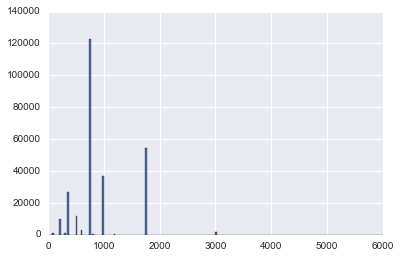

In [46]:
df['BottleVolumeml'].hist(bins = 200)

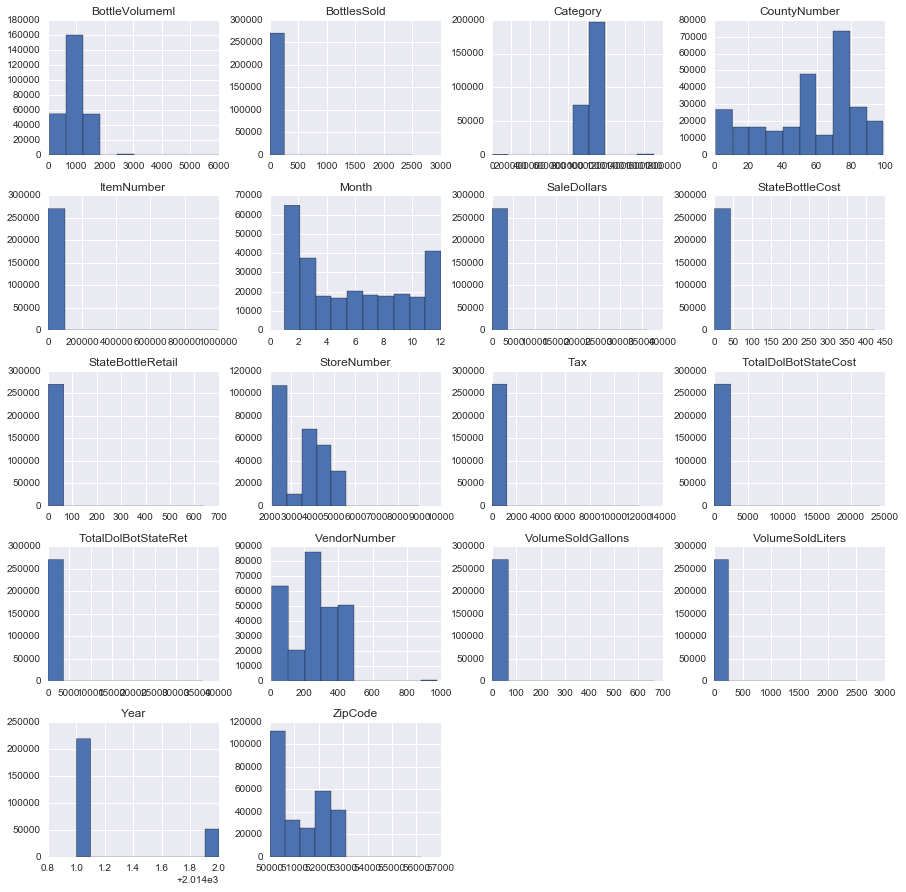

In [52]:
# Overview of histograms

df.hist(figsize=(15,15));

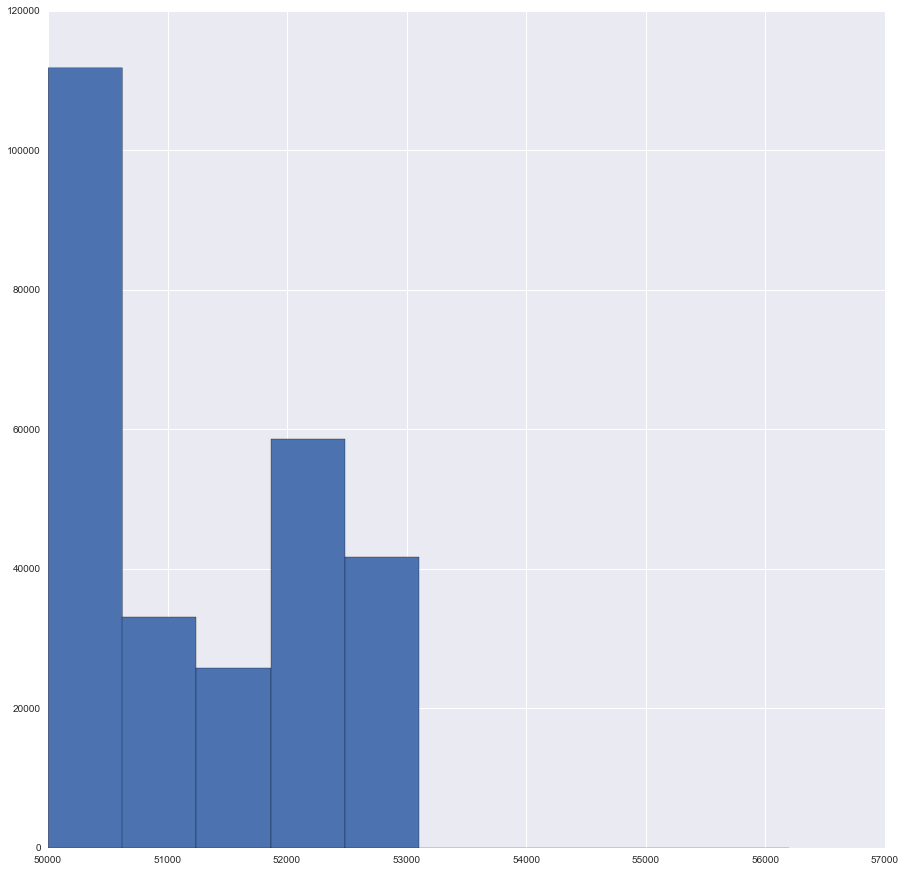

In [53]:
# Overview of histograms

df['ZipCode'].hist(figsize=(15,15));

In [54]:
df['City'].nunique()

385

In [55]:
df.dtypes

Date                    datetime64[ns]
StoreNumber                      int64
City                            object
ZipCode                          int64
CountyNumber                     int64
County                          object
Category                         int64
CategoryName                    object
VendorNumber                     int64
ItemNumber                       int64
ItemDescription                 object
BottleVolumeml                   int64
StateBottleCost                float64
StateBottleRetail              float64
BottlesSold                      int64
SaleDollars                    float64
VolumeSoldLiters               float64
VolumeSoldGallons              float64
Year                             int64
Month                            int64
TotalDolBotStateCost           float64
TotalDolBotStateRet            float64
Tax                            float64
dtype: object

In [56]:
df['Tax'].describe()

count    270955.000000
mean         43.097436
std         128.597325
min           0.000000
25%          10.165000
50%          23.520000
75%          45.000000
max       12130.800000
Name: Tax, dtype: float64

In [62]:
#summaries by city
totals_bycity3_df = df.groupby(['City', 'Year'])["BottlesSold"].agg({'TotalBottlesSold':sum})
totals_bycity3_df.reset_index(inplace=True)
totals_bycity3_df.stack(level=0, dropna=True)
totals_bycity3_df.head(3)

totals_bycity2_df = df.groupby(['City', 'Year'])["SaleDollars"].agg({'TotalSaleDollars':sum})
totals_bycity2_df.reset_index(inplace=True)
totals_bycity2_df.stack(level=0, dropna=True)
totals_bycity2_df.head(3)

totals_bycity1_df = df.groupby(['City', 'Year'])["StoreNumber"].agg({'TotalNoStores':lambda x: x.nunique()})
totals_bycity1_df.reset_index(inplace=True)
totals_bycity1_df.stack(level=0, dropna=True)
totals_bycity1_df.head(3)

totals_bycity4_df = df.groupby(['City', 'Year'])["Tax"].agg({'TotalTaxDollars':sum})
totals_bycity4_df.reset_index(inplace=True)
totals_bycity4_df.stack(level=0, dropna=True)
totals_bycity4_df.head(3)

#summaries by city . Merge Above dataframe to create a dataframe by city for plotting

best_stores_2015_city = pd.merge(pd.merge(\
pd.merge(totals_bycity1_df[totals_bycity1_df['Year']==2015],\
                  totals_bycity2_df[totals_bycity2_df['Year']==2015], on=['City','Year'])\
        ,totals_bycity3_df[totals_bycity3_df['Year']==2015] , on=(['City', 'Year'])),\
                                   totals_bycity4_df[totals_bycity4_df['Year']==2015] , on=(['City', 'Year'])).sort_values('City')
    
    
best_stores_2015_city.head(3)


best_stores_2016_city = pd.merge(pd.merge(\
pd.merge(totals_bycity1_df[totals_bycity1_df['Year']==2016],\
                  totals_bycity2_df[totals_bycity2_df['Year']==2016], on=['City','Year'])\
        ,totals_bycity3_df[totals_bycity3_df['Year']==2016] , on=(['City', 'Year'])),\
                                   totals_bycity4_df[totals_bycity4_df['Year']==2016] , on=(['City', 'Year'])).sort_values('City')
    
best_stores_2015_city.head(3)
    
#sort by total prfit to know the 10 more Taxable counties YEAR 2015
best_stores_2015_city = best_stores_2015_city.sort(['TotalTaxDollars'], ascending=[0])
best_stores_2015_city.head(3)
                             
#sort by total prfit to know the 10 more Taxable counties YEAR 216

best_stores_2016_city = best_stores_2016_city.sort(['TotalTaxDollars'], ascending=[0])
best_stores_2016_city.head(3)                             

best_stores_2015_city.reset_index(drop=True)
best_stores_2016_city.reset_index(drop=True)

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:35: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:40: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,City,Year,TotalNoStores,TotalSaleDollars,TotalBottlesSold,TotalTaxDollars
0,DES MOINES,2016,76,814355.45,65250,271700.52
1,CEDAR RAPIDS,2016,71,437361.85,34805,145953.13
2,DAVENPORT,2016,44,319680.64,30601,106653.37
3,SIOUX CITY,2016,34,261621.86,18845,87439.03
4,COUNCIL BLUFFS,2016,38,250016.18,17402,83399.73
5,IOWA CITY,2016,25,232506.06,18289,77568.16
6,WATERLOO,2016,40,228750.20,20717,76321.35
7,WEST DES MOINES,2016,29,222532.42,14210,74225.29
8,DUBUQUE,2016,28,179402.17,13430,59869.13
9,AMES,2016,24,169224.29,11785,56495.34


In [88]:
#summaries by county

totals_bycounty3_df = df.groupby(['County'])["BottlesSold"].agg({'TotalBottlesSold':sum})
totals_bycounty3_df.reset_index(inplace=True)
totals_bycounty3_df.stack(level=0, dropna=True)
totals_bycounty3_df.head(3)

totals_bycounty2_df = df.groupby(['County'])["SaleDollars"].agg({'TotalSaleDollars':sum})
totals_bycounty2_df.reset_index(inplace=True)
totals_bycounty2_df.stack(level=0, dropna=True)
totals_bycounty2_df.head(3)

totals_bycounty1_df = df.groupby(['County'])["StoreNumber"].agg({'TotalNoStores':lambda x: x.nunique()})
totals_bycounty1_df.reset_index(inplace=True)
totals_bycounty1_df.stack(level=0, dropna=True)
totals_bycounty1_df.head(3)

totals_bycounty4_df = df.groupby(['County'])["StateBottleRetail"].agg({'StateBottleRetailMed':np.median})
totals_bycounty4_df.reset_index(inplace=True)
totals_bycounty4_df.stack(level=0, dropna=True)
totals_bycounty4_df.head(3)

totals_bycounty5_df = df.groupby(['County'])["VendorNumber"].agg({'TotalNoVendors':lambda x: x.nunique()})
totals_bycounty5_df.reset_index(inplace=True)
totals_bycounty5_df.stack(level=0, dropna=True)
totals_bycounty5_df.head(3)

best_stores_county = pd.merge(pd.merge(pd.merge(\
pd.merge(totals_bycounty1_df,\
                 totals_bycounty2_df, on=['County'])\
       ,totals_bycounty3_df , on=(['County'])),\
                                  totals_bycounty4_df), \
        totals_bycounty5_df, on=(['County'])).sort_values('County')

result = pd.merge(best_stores_county, demo_df,  on='County')

result = pd.merge(result, empl_df,  on='County')

result = pd.merge(result, po21_df,  on='County')

result.head()

,County,TotalNoStores,TotalSaleDollars,TotalBottlesSold,StateBottleRetailMed,TotalNoVendors,Population,Average of LABORFORCE,Average of EMPLAB,Average of UNEMP,Average of UNEMPRATE,Prop. Male,Prop. Female,Prop. Population over 21
0,Adair,8,55581.34,4653,12.300,30,7228,4268.33,4131.67,135.83,3.17,0.49,0.51,0.86
1,Adams,1,12441.71,955,13.545,26,3796,2300.83,2235.83,63.33,2.76,0.49,0.51,0.88
2,Allamakee,6,99024.76,7452,12.380,36,13886,7725.83,7354.17,373.33,4.83,0.51,0.49,0.86
3,Appanoose,6,98527.16,8176,11.810,36,12529,6255.83,5954.17,300.83,4.81,0.49,0.51,0.87
4,Audubon,4,19842.23,1721,11.240,20,5773,3251.67,3126.67,126.67,3.89,0.48,0.52,0.88


In [ ]:
hist_df = df.groupby(['StoreNumber'])['VolumeSoldGallons', 'BottlesSold', 'StateBottleRetail', 'SaleDollars' ].agg([sum], margins=True)
hist_df.head()

Here we can take a look at the distribution of bottles in each order. The histograme below breaks the data into one bin for each bottle. We can see two major spikes in the data at 12 and 6. This is expected as a liquor is often sold as a case of 12 or a half case of 6. This histogram is affected by the size of each order so a store that makes two orders of 3 bottles versus one order of 6 bottles will affect the data. Below we've group the data by store to take a look at the distribution of how many bottles each store is odering. 

In [ ]:
plt.hist(df['BottlesSold'], range=(0, 50), bins=50)
plt.style.use('seaborn-deep')
plt.xlabel('Bottles per Order')
plt.ylabel('Frequency')
plt.title(r'Histogram of Iowa Liquor Store Orders', y=1.08)
plt.show()

This histogram below shows how many bottles each store is odering. We can see that most stores order between about 250 and 750 bottles and then it begins to train off in a right skewed distribution. You should expect to sell somewhere around the mode of 312 the for any new stores that open. 

In [ ]:
hist_df['BottlesSold'].hist(range=(0,3000), bins=20)
plt.style.use('seaborn-deep')
plt.xlabel('Bottles per Store')
plt.ylabel('Frequency')
plt.title(r'Histogram of Iowa Liquor Store Orders', y=1.08)
plt.show()

Taking a look at the distribution of Sales Dollars per order, we can see the majority of oders are small, and then follow a near perfect log-normal distribution trailing off as orders become more expensive. This is affected by the buying habits of individual stores. Namely, do they make frequent small purchases or few large purchases. We'll group it by individual stores below. 

In [ ]:
ax = plt.hist(df['SaleDollars'], range=(0, 500), bins=20)
plt.style.use('seaborn-deep')
plt.xlabel('Sales($) by Order')
plt.ylabel('Frequency')
plt.title(r'Histogram of Iowa Liquor Sales', y=1.08)
plt.show()

The histogram below shows the distribution by store of much sales the state makes to those individual stores. We can see a skewed right distribution. Most stores purchase between $2,500 and $7,500. However, we can see there is a fatter tail than some of the distributions. Any new store that opens should expect to fall somewhere around the mode of this distribution. 

In [ ]:
hist_df['SaleDollars'].hist(range=(0,40000), bins= 40)
plt.style.use('seaborn-deep')
plt.xlabel('Sales per Store')
plt.ylabel('Frequency')
plt.title(r'Histogram of Iowa Liquor Store Purchases', y=1.08)
plt.show()

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

In [ ]:
df.head(3)

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [97]:
#Create a dummy for county
county_dummy = {}
counter = 0
for i in df['County'].unique():
    county_dummy[i] = counter
    counter += 1
result['county_dummy'] = result['County'].map(county_dummy)

In [104]:
# for iv in result.columns.values:
#     sns.jointplot(x=results[iv], y=targets['TotalSaleDollars'])

NameError: name 'results' is not defined

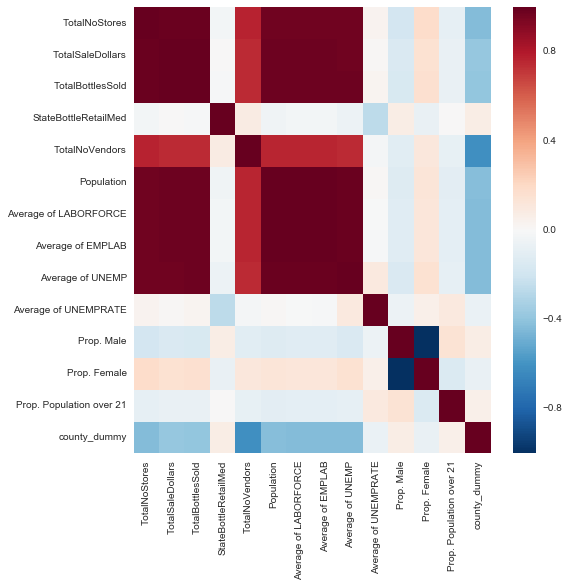

In [106]:
sns.set(rc={"figure.figsize": (8, 8)});
sns.heatmap(result.corr())

In [ ]:
# For our model, our features are: 
# 1.Total number of stores, 
# 2.total bottles sold
# 3.total number of vendors (variety of product in store increases sales)
# 4.county_dummy
# 5.Average of LABORFORCE

In [176]:
result_features = {'County_Dummy':result['county_dummy'].values,'Total_No_Stores':result['TotalNoStores'].values, 'Total_Bottles_Sold':result['TotalBottlesSold'].values, 'Total_No_Vendors':result['TotalNoVendors'], 'Average_Laborforce':result['Average of LABORFORCE']}
result_label = [item for item in result['TotalSaleDollars'].values]  
np.asarray(result_label)

array([  5.55813400e+04,   1.24417100e+04,   9.90247600e+04,
         9.85271600e+04,   1.98422300e+04,   8.00636100e+04,
         1.93996530e+06,   2.53390130e+05,   2.07252090e+05,
         2.86780170e+05,   2.14559380e+05,   3.40996300e+04,
         3.59925300e+04,   3.07335410e+05,   1.31086830e+05,
         7.29537300e+04,   6.98364650e+05,   8.72938400e+04,
         4.44572600e+04,   7.91767800e+04,   1.77249820e+05,
         8.98331300e+04,   4.22759470e+05,   1.55494180e+05,
         2.64294820e+05,   1.31975200e+04,   1.98052800e+04,
         1.01095240e+05,   4.68105530e+05,   4.53477250e+05,
         1.08938538e+06,   6.82194700e+04,   1.55308380e+05,
         1.49402510e+05,   6.47486400e+04,   3.55763000e+03,
         7.49232600e+04,   3.89583100e+04,   3.78666900e+04,
         1.04248010e+05,   3.70148400e+04,   1.54759200e+05,
         6.47571300e+04,   1.46004480e+05,   9.51462200e+04,
         6.14282500e+04,   7.61940800e+04,   8.97792770e+05,
         1.55546030e+05,

In [177]:
X = pd.DataFrame(result_features)
y = result_label

In [178]:
lr = linear_model.LinearRegression()
lr_model = lr.fit(X,y)
lr_model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [179]:
y_true = np.array(y)
y_pred = lr_model.predict(X)

lr_r2 =  r2_score(y_true=y_true, y_pred=y_pred)
lr_r2

0.99613143992353048

## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

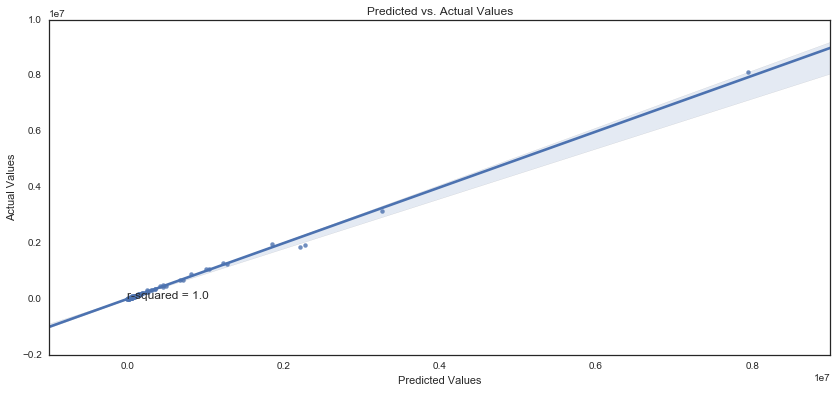

In [181]:
plt.style.use('seaborn-white')

ax = sns.regplot(y_pred, y_true)
ax.figure.set_figheight(6)
ax.figure.set_figwidth(14)
plt.annotate('r-squared = ' + str(round(lr_r2,2)), xy=(41,-7), fontsize=12)
ax.set_ylabel('Actual Values')
ax.set_xlabel('Predicted Values')
ax.set_title('Predicted vs. Actual Values');

In [119]:
abs(lr_model.coef_).mean()

704.23344567447998

In [120]:
lr_model.coef_.max()

570.01515441703373

In [121]:
lasso = linear_model.Lasso(alpha=1)

In [122]:
lasso_model = lasso.fit(X, y)

In [129]:
y_true_lasso = y
y_pred_lasso = lasso_model.predict(X)

lasso_r2 =  r2_score(y_true=y_true_lasso, y_pred=y_pred_lasso)

In [130]:
lasso_r2

0.99613143992338105

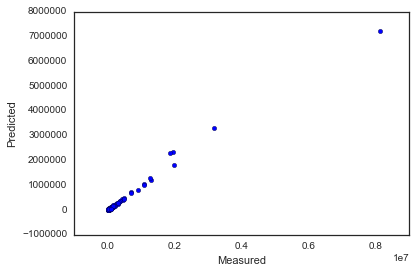

r^2: [ 0.94949724  0.98832043  0.98329862  0.99675497  0.97831623  0.99582871
  0.9875558   0.98526293  0.94446785  0.99850153]


In [138]:
plt.style.use('seaborn-white')

lr = linear_model.Lasso(normalize=True)
predicted = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted)

ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()
print "r^2:", cross_val_score(lr, X, y, cv=10)

In [146]:
my_df = result.sort_values(by="TotalSaleDollars", ascending=False)
my_df.reset_index(inplace=True)
my_df.head(10)

,index,County,TotalNoStores,TotalSaleDollars,TotalBottlesSold,StateBottleRetailMed,TotalNoVendors,Population,Average of LABORFORCE,Average of EMPLAB,Average of UNEMP,Average of UNEMPRATE,Prop. Male,Prop. Female,Prop. Population over 21,county_dummy
0,76,Polk,210,8.121854e+06,596571,12.38,103,467711,255758.33,246600.00,9183.33,3.58,0.49,0.51,0.85,8
1,56,Linn,104,3.165472e+06,247691,11.76,78,219916,119816.67,115366.67,4458.33,3.71,0.49,0.51,0.86,5
2,51,Johnson,47,1.962554e+06,137611,12.38,84,144251,83891.67,81716.67,2191.67,2.60,0.50,0.50,0.87,12
3,6,Black Hawk,73,1.939965e+06,173653,11.43,70,133455,70491.67,67325.00,3166.67,4.50,0.49,0.51,0.87,2
4,81,Scott,56,1.857637e+06,165905,11.21,65,172126,87141.67,83125.00,4025.00,4.61,0.49,0.51,0.86,1
5,77,Pottawattamie,53,1.280695e+06,95411,11.40,60,93671,49275.00,47508.33,1758.33,3.57,0.49,0.51,0.86,17
6,96,Woodbury,38,1.269002e+06,96169,12.30,68,102782,55891.67,53816.67,2083.33,3.72,0.49,0.51,0.85,23
7,30,Dubuque,41,1.089385e+06,80308,12.38,54,97125,55741.67,53733.33,2000.00,3.58,0.49,0.51,0.86,30
8,84,Story,38,1.075273e+06,76886,12.38,80,96021,57375.00,55991.67,1375.00,2.41,0.52,0.48,0.86,3
9,47,Iowa,27,8.977928e+05,61838,13.01,68,16401,10410.00,10052.50,358.33,3.46,0.49,0.51,0.86,51


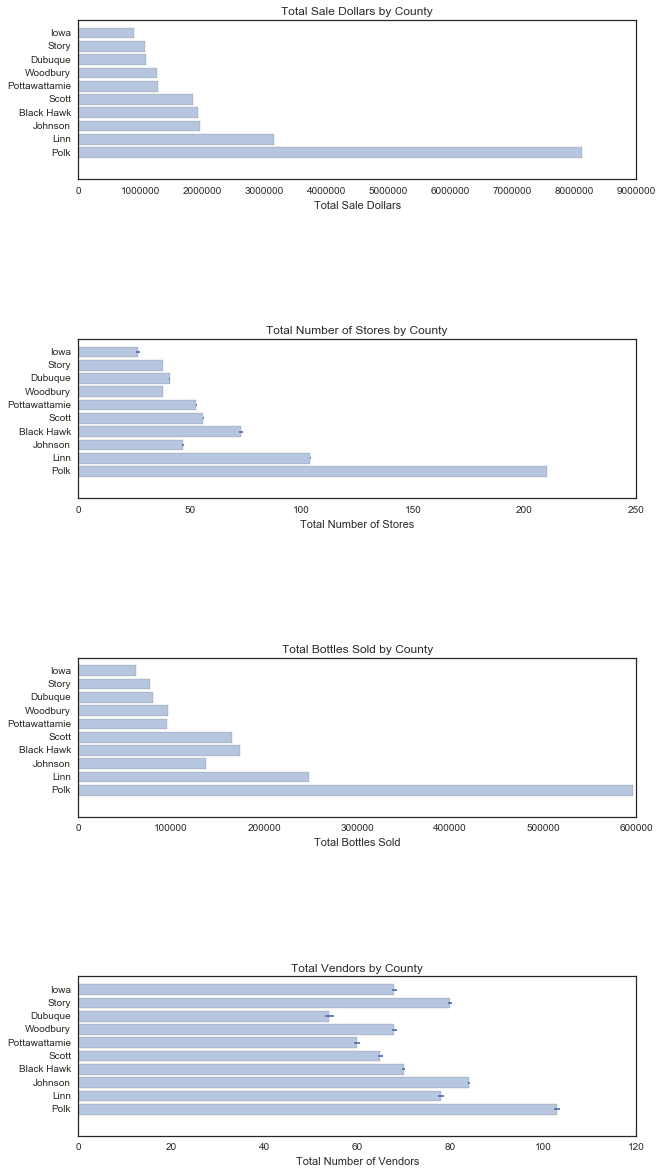

In [156]:
fig, axes = plt.subplots(4,1, figsize=(10,20))

plt.subplot(411)
plt.subplots_adjust(hspace=1)
counties = my_df['County'].head(10).values
y_pos = np.arange(len(counties))
performance = my_df['TotalSaleDollars'].head(10).values
error = np.random.rand(len(counties))

plt.barh(y_pos, performance, xerr=error, align='center', alpha=0.4)
plt.yticks(y_pos, counties)
plt.xlabel('Total Sale Dollars')
plt.title('Total Sale Dollars by County')

plt.subplot(412)
plt.subplots_adjust(hspace=1)
counties = my_df['County'].head(10).values
y_pos = np.arange(len(counties))
performance = my_df['TotalNoStores'].head(10).values
error = np.random.rand(len(counties))

plt.barh(y_pos, performance, xerr=error, align='center', alpha=0.4)
plt.yticks(y_pos, counties)
plt.xlabel('Total Number of Stores')
plt.title('Total Number of Stores by County');

plt.subplot(413)
plt.subplots_adjust(hspace=1)
counties = my_df['County'].head(10).values
y_pos = np.arange(len(counties))
performance = my_df['TotalBottlesSold'].head(10).values
error = np.random.rand(len(counties))

plt.barh(y_pos, performance, xerr=error, align='center', alpha=0.4)
plt.yticks(y_pos, counties)
plt.xlabel('Total Bottles Sold')
plt.title('Total Bottles Sold by County');

plt.subplot(414)
plt.subplots_adjust(hspace=1)
counties = my_df['County'].head(10).values
y_pos = np.arange(len(counties))
performance = my_df['TotalNoVendors'].head(10).values
error = np.random.rand(len(counties))

plt.barh(y_pos, performance, xerr=error, align='center', alpha=0.4)
plt.yticks(y_pos, counties)
plt.xlabel('Total Number of Vendors')
plt.title('Total Vendors by County');

In [ ]:
#Join predictions to a dataframe

import pandas
import numpy


dtype = [('predictions','float32')]
values = [predictions[i] for i in range(0, len(predictions))]
index = [i for i in range(0, len(predictions))]



df2 = pandas.DataFrame(values)
df2[0]
#len(df2)
dfx1 = dfx
#len(predictions)
dfx1 ['Predictions'] = df2[0]
dfx1 ['TotalSaleDollars'] = targets["TotalSaleDollars"]
dfx1
#dfx1 ['SalesDollars'] = targets['SaleDollars']
#dfx1['Predictions'].head(5)


# Summary

At the outset, we intended to discover the features most highly correlated with liquor sales to determine which geographic locations would be most suitable for an entrepreneur looking to build or exand their liquor franchise in Iowa. 

After reviewing the existing literature on the subject, we found five recurring features correlated with liquor consumption. These five features were:

1. The density of alcohol vendors in a given neighborhood, and resultant access to alcohol, seemed to increase alcohol consumption.$^1$$^,$$^2$
2. Economic Factors - Better economy, better booze sales.$^3$
3. Gender - Men are more likely to binge drink than women.$^3$
4. Age Profile - The proportion of people in the region over the U.S. legal drinking age of 21.$^4$
5. Population Density - More people, more alcohol consumption.$^3$

We appended additional demographic data to our existing Iowa government dataset to test the correlation between these features, as well as the included features, and alcohol sales. After running a seaborn heatmap on the correlation between these features, we whittled down the number of features most highly correlated with total sales to just four: total number of stores (store density per county), total bottles sold (per county), total number of vendors (diversity of product offerings) and average labor force (employment metric, at the county level). We then built a linear regression to model the relationship between these four features and sales.

As was borne out by the model, these four features were extremely highly correlated with liquor sales -- giving us an r squared of .99. We cross validated our linear regression model with a lasso regression, which returned comparably high r squared values, ranging from .94 to .99 over 10 cross validations. 

# Risks and Assumptions

A brief, important word should be devoted to the nature of the dataset and to the high r-squared. Our dataset consisted of features that were very highly collinear with sales, some definitionally so. For example, the 'Sales (Dollars)' column in the original dataset (renamed "TotalSalesDollars") was simply the product of the 'State Bottle Retail' column and the 'Bottles Sold' column. Thus, if looking at features correlated with 'Sales (Dollars)', we definitionally have two features that can describe all movement in 'Sales (Dollars)'. As a result of this, we would expect most properly executed models using this dataset to have very high r squared's.

One major, implicit assumption that we make in all of this is that 'Sales (Dollars)', viewed at any level of specificity (store level, county level, zip code level), is an indicator of profitability, and it is not. This feature is a misnomer - the 'Sale (Dollars)' column reflects the cost a point of sale incurred when purchasing the liquor from the Iowa government. The extent to which the retailer is marking up the liquor and the speed at which they're turning their inventory is completely unknown. We assume that stores buying lots of liquor are selling a lot too but we don't know at the individual store level whether this is true at all, given the data. 

# Results

Our analysis, which was conducted at the county level, shows that the 10 Iowa counties most with the highest sales, in order, are:

1. Polk
2. Linn
3. Johnson
4. Black Hawk
5. Scott
6. Pottawattamie
7. Woodbury
8. Dubuque
9. Story
10. Iowa County

For an entrepreneur looking to set up shop or expand further into Iowa, these locales would be the soundest places to start. Given our model's fit with the data and the tremendously high r squared, it is very unlikely that there would be material variance in 'Sales (Dollars)' for the entrepreneur, and these 10 counties represent the top of the 'Sales (Dollars)' list. 

# Sources 
1. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2936987/; accessed 10/12/2015
2. http://www.arcr.niaaa.nih.gov/arcr/arcr381/article08.htm; accessed 10/12/2015 
3. http://www.usatoday.com/story/money/business/2015/07/02/24-7-wall-st-states-drinking-most-beer/29574619/; accessed 10/12/2015
4. http://helenair.com/news/state-and-regional/demographic-factors-also-influence-drinking-and-driving/article_fdd73b94-3a30-11df-a889-001cc4c03286.html; accessed 10/12/2015